In [1]:
#This is a dummie file for a git hub push test
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels as smodel
import sklearn
from sklearn import datasets, linear_model, metrics
import statsmodels.formula.api as stmf
import os
import re
import unicodedata
#import nltk
#from wordcloud import WordCloud, STOPWORDS
# Imports from sklearn for ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression


# NY DATA
nyDataFrame = pd.read_csv('AB_NYC_2019.csv')
nyDataFrame['coordinates'] = nyDataFrame['latitude'].astype(str) + ', ' + nyDataFrame['longitude'].astype(str)
del nyDataFrame['latitude']
del nyDataFrame['longitude']

# Replace neighborhood group with city
nyDataFrame.columns = ['city' if x=='neighbourhood_group' else x for x in nyDataFrame.columns]
# Move city column towards beginning
nyDataFrame = nyDataFrame[["id","host_id","name","host_name","city","neighbourhood","room_type","price","minimum_nights","number_of_reviews","last_review",
                             "reviews_per_month","calculated_host_listings_count","availability_365","coordinates"]]
# Group by city and neighborhood and sort by the most number of reviews
nyDataFrame.sort_values(["city","neighbourhood","number_of_reviews"],ascending = [True,True,False])



,id,host_id,name,host_name,city,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,coordinates
510,182177,873273,A PRIVATE FLAT / APARTMENT- $SPECIAL$,Christian & Carla,Bronx,Allerton,Entire home/apt,125,2,271,2019-06-20,2.84,2,347,"40.86466, -73.85709"
1666,755528,3684360,PRIVATE BATH/TONS OF SUNLIGHT/SAFE,Enrique,Bronx,Allerton,Entire home/apt,49,2,189,2019-06-23,2.32,4,238,"40.8584, -73.86969"
1706,773041,3684360,Nice beautiful room In the Bronx,Enrique,Bronx,Allerton,Private room,38,1,187,2019-06-23,2.34,4,241,"40.859140000000004, -73.86979000000001"
1578,715270,3684360,2 Beds/Queen & Full Beautiful Room 40 minsT.Sq...,Enrique,Bronx,Allerton,Private room,39,2,169,2019-06-12,2.07,4,306,"40.859559999999995, -73.87066999999999"
4795,3400359,16286162,Awesome Deal NYC,Pat,Bronx,Allerton,Private room,49,2,114,2019-06-29,1.87,4,240,"40.86677, -73.85938"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47757,35901040,92493393,Private Cozy Three Bedroom apartment for 8,Eddie & Lois,Staten Island,West Brighton,Entire home/apt,190,1,0,NaN,NaN,5,342,"40.63207, -74.11406"
29214,22420304,164164069,Nice bunkbed room with private bathroom!,Marcia,Staten Island,Westerleigh,Private room,40,2,17,2018-09-07,0.92,1,36,"40.61422, -74.13167"
23449,18993379,132266502,Home &Garden: lots local+fast 2 Manhattan/Broo...,Sharlene,Staten Island,Westerleigh,Entire home/apt,103,3,1,2018-07-29,0.09,1,189,"40.61357, -74.13566"
34161,27088022,115827173,"Bright, Brand NEW, and Spacious, Gorgeous Home",David,Staten Island,Willowbrook,Entire home/apt,249,4,9,2019-05-13,0.80,2,351,"40.598859999999995, -74.13217"


In [2]:

# USA DATA
usaDataFrame = pd.read_csv('AB_US_2020.csv')
del usaDataFrame['neighbourhood_group']
usaDataFrame['coordinates'] = usaDataFrame['latitude'].astype(str) + ', ' + usaDataFrame['longitude'].astype(str)
del usaDataFrame['latitude']
del usaDataFrame['longitude']

# Make city column one of the first few columns
usaDataFrame = usaDataFrame[["id","host_id","name","host_name","city","neighbourhood","room_type","price","minimum_nights","number_of_reviews",
                             "last_review","reviews_per_month","calculated_host_listings_count","availability_365","coordinates"]]
# Group by city and neighborhood and sort by the most number of reviews
usaDataFrame.sort_values(["city","neighbourhood","number_of_reviews"],ascending = [True,True,False])


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,host_id,name,host_name,city,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,coordinates
276,11701027,37737144,Spacious 700 sq. ft. Suite in South Asheville,Kwadwo,Asheville,28704,Entire home/apt,66,1,355,10/09/20,6.42,4,0,"35.47528, -82.50271"
738,21947972,141218676,Houz Zen: A Pet Friendly Private Suite,Corey,Asheville,28704,Entire home/apt,90,2,320,22/09/20,9.47,2,0,"35.45308, -82.50511"
352,13700790,37737144,Cozy Room in South Asheville,Kwadwo,Asheville,28704,Private room,44,1,307,20/09/20,5.95,4,343,"35.4749, -82.50163"
820,23498234,169331389,Bran Rick Cabin,Eric,Asheville,28704,Private room,52,1,281,20/09/20,9.09,1,341,"35.44491, -82.55249"
157,5850649,30377862,Explore the Woods from a Quiet Apartment near ...,Daniel,Asheville,28704,Entire home/apt,102,7,263,03/04/20,4.95,1,0,"35.44968, -82.5197"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222492,23731595,59460146,DC Room - Queen bed and full bath,Ryan,Washington D.C.,"Woodridge, Fort Lincoln, Gateway",Private room,150,1,0,NaN,NaN,1,90,"38.92537, -76.95347"
222738,25294169,191067732,Cozy guest bedroom,Tierra,Washington D.C.,"Woodridge, Fort Lincoln, Gateway",Private room,65,1,0,NaN,NaN,1,364,"38.92248, -76.95059"
224443,38189405,104560694,PEACH PARADISE @ Woodridge Abbey Bed & Breakfast,Michelle,Washington D.C.,"Woodridge, Fort Lincoln, Gateway",Private room,30,14,0,NaN,NaN,2,0,"38.92998, -76.96535"
225104,42061938,331138523,"Cozy, Clean , Convenient DC home!",Chikere,Washington D.C.,"Woodridge, Fort Lincoln, Gateway",Private room,55,2,0,NaN,NaN,1,0,"38.9217, -76.9657"


In [3]:
# SEATTLE DATA
seattleDataFrame = pd.read_csv('seattle_01.csv')
del seattleDataFrame['rate_type']
seattleDataFrame['coordinates'] = seattleDataFrame['latitude'].astype(str) + ', ' + seattleDataFrame['longitude'].astype(str)
del seattleDataFrame['latitude']
del seattleDataFrame['longitude']

# Delete random column
del seattleDataFrame['Unnamed: 0']

# Move name column towards beginning
seattleDataFrame = seattleDataFrame[["room_id","host_id","name","room_type","address","reviews", 
    "overall_satisfaction","accommodates","bedrooms","bathrooms","price","last_modified","location","currency","coordinates"]]

# Group by address and sort by the most number of reviews
seattleDataFrame.sort_values(["reviews"],ascending = [False])


,room_id,host_id,name,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,location,currency,coordinates
28,25002,102684,"Beautiful, Private Spot in Quiet Ballard",Entire home/apt,"Seattle, WA, United States",687,5.0,4,1.0,1.0,70,2018-12-20 02:58:36.967441,0101000020E6100000087767EDB6975EC04641F0F8F6D6...,USD,"47.679412, -122.37054"
702,3861673,19928221,Beautiful Guest Suite for 2 in Ballard,Entire home/apt,"Seattle, WA, United States",644,5.0,2,1.0,1.0,45,2018-12-20 02:52:55.955789,0101000020E61000000EF96706F1975EC0CFBD874B8ED7...,USD,"47.68403, -122.374086"
399,1758935,3401993,Ethiopian cottage #1/Private Bath,Private room,"Seattle, WA, United States",513,4.5,2,1.0,1.0,45,2018-12-20 04:02:40.140693,0101000020E61000005322895E46925EC07C7C4276DEC8...,USD,"47.56928900000001, -122.285545"
22,20927,79450,Cottage in the Heart of Ballard,Entire home/apt,"Seattle, WA, United States",489,5.0,2,1.0,1.0,59,2018-12-20 02:58:36.953496,0101000020E6100000B77F65A549995EC0880FECF82FD6...,USD,"47.673339, -122.39512"
511,2686374,2231298,Bunkhouse 2nd floor & Airstream-No cleaning fees,Entire home/apt,"Seattle, WA, United States",488,5.0,6,2.0,1.5,125,2018-12-20 03:05:39.14014,0101000020E610000025CB49287D985EC052B81E85EBD5...,USD,"47.67125, -122.38263899999998"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6682,28273572,207109604,Pike Place Diamond,Entire home/apt,"Seattle, United States",0,NaN,3,0.0,1.0,76,2018-12-20 03:55:50.263555,0101000020E61000001AC1C6F5EF955EC03049658A39CE...,USD,"47.611131, -122.342771"
6684,28273697,207109604,Pike Place Violet,Entire home/apt,"Seattle, United States",0,NaN,3,1.0,1.0,84,2018-12-20 03:55:58.683095,0101000020E610000069C6A2E9EC955EC059164CFC51CE...,USD,"47.611877, -122.342585"
6686,28273921,207109604,Pike Place Spark,Entire home/apt,"Seattle, United States",0,NaN,3,1.0,1.0,43,2018-12-20 03:49:16.447086,0101000020E6100000A77A32FFE8955EC04626E0D748CE...,USD,"47.611598, -122.342346"
6689,28284668,213606620,Floating Hostess with the Mostess,Private room,"Seattle, WA, United States",0,NaN,2,1.0,1.0,121,2018-12-20 03:29:40.632318,0101000020E61000003F55850662985EC0967A1684F2D4...,USD,"47.663651, -122.380983"


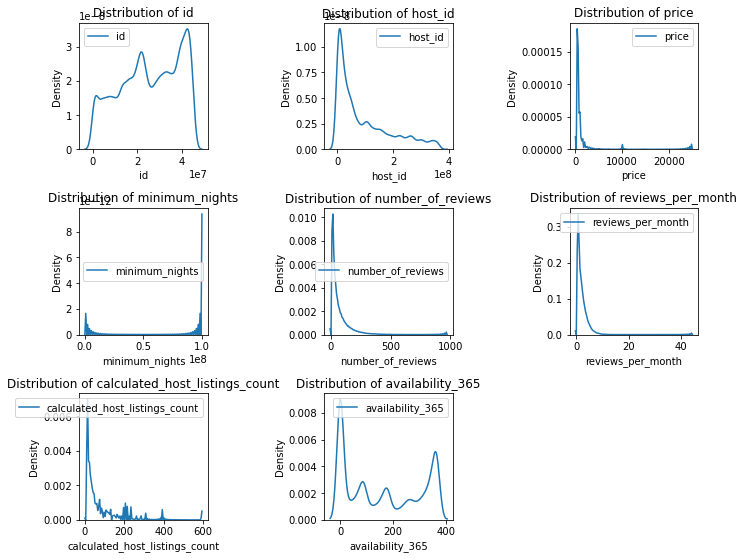

In [4]:
#Dealing with nulls in USA data
usaDataFrame.isnull().sum()
usaData2 = usaDataFrame
#check for the num of unique data points in each feature
usaData2.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
usaData2.select_dtypes('int').apply(pd.Series.nunique, axis = 0)
usaData2.select_dtypes('float').apply(pd.Series.nunique, axis = 0)
#Outliers
distr_numeric = usaDataFrame.select_dtypes(include=('int', 'float')).columns
plt.figure(figsize = (10,10))

for i, each in enumerate(distr_numeric):
    plt.subplot(4,3,i+1)
    sb.kdeplot(usaDataFrame[each])
    plt.title('Distribution of %s' %each)
    plt.xlabel('%s' %each); plt.ylabel('Density')
    plt.tight_layout()

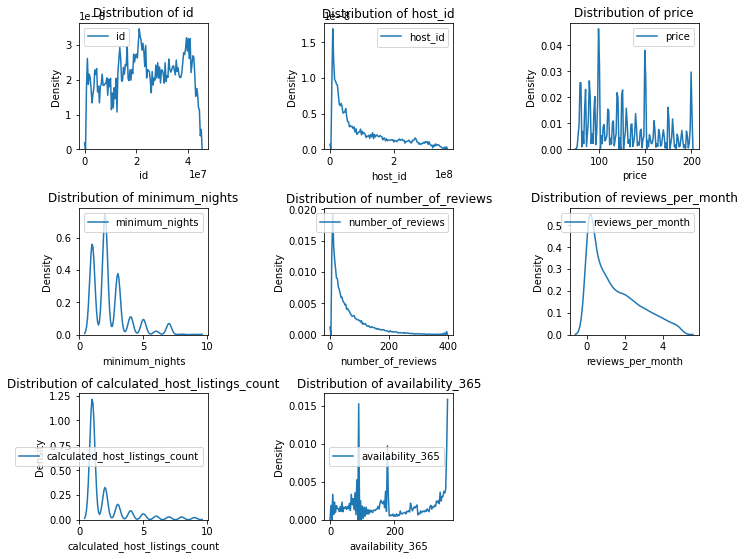

In [5]:
ubound = .75
lbound = .25
cleaned = usaDataFrame[usaDataFrame['price'].between(usaDataFrame['price'].quantile(lbound), usaDataFrame['price'].quantile(ubound), inclusive = True)]
cleaned = cleaned[cleaned['number_of_reviews']>0]
cleaned = cleaned[cleaned['reviews_per_month']<5]
cleaned = cleaned[cleaned['minimum_nights']<10]
cleaned = cleaned[cleaned['calculated_host_listings_count']<10]
cleaned = cleaned[cleaned['number_of_reviews']<400]
#Any other ideas of what limits to put?
numeric_Cleaned = cleaned.select_dtypes(include = ('float', 'int')).columns
plt.figure(figsize=(10,10))
for i, each in enumerate(numeric_Cleaned):
    plt.subplot(4,3,i+1)
    sb.kdeplot(cleaned[each], bw = .2)
    plt.title('Distribution of %s' %each)
    plt.xlabel('%s' %each); plt.ylabel('Density')
    plt.tight_layout()
    
#Words to describe things we can learn from the below graphs.
cleanedUsaData = cleaned.copy(deep=True)


reviews_per_month                -0.066397
number_of_reviews                -0.056982
id                               -0.007779
host_id                           0.007055
calculated_host_listings_count    0.026635
availability_365                  0.045928
minimum_nights                    0.093901
price                             1.000000
Name: price, dtype: float64

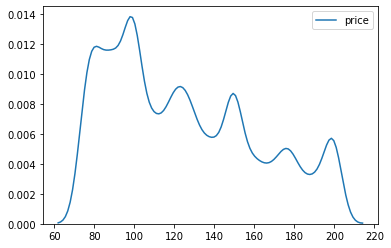

In [8]:
#Explore Numeric Features
#Feature 1 Price:
cleanedUsaData['price'].describe()
cleanedUsaData
sb.kdeplot(cleanedUsaData['price'])
#__________(Add Description of what this means)
#You can see the peak in the blah blah 
#You can see the correlation of numerical features and pricing. 
#&Jerry write more stuff for this!&

correlated = cleanedUsaData.corr()['price'].sort_values()
correlated
#&Graph to display correlation here (PLS do this)&

(array([16902., 22272., 11317.,  3346.,     0.,  2846.,   646.,  2059.,
           85.,    40.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

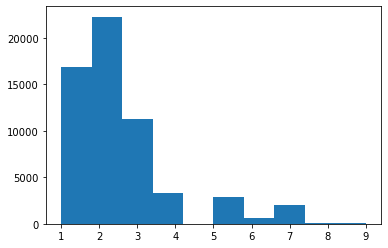

In [9]:
#Feature 2: Minimum Nights
plt.hist(cleanedUsaData['minimum_nights'])
#plot comparing reviews per month and minimum nights

(array([37749.,  9821.,  5295.,  2888.,  1687.,   992.,   558.,   294.,
          148.,    81.]),
 array([  1. ,  40.8,  80.6, 120.4, 160.2, 200. , 239.8, 279.6, 319.4,
        359.2, 399. ]),
 <a list of 10 Patch objects>)

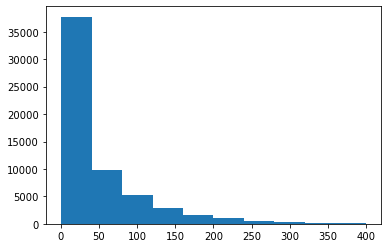

In [10]:
# Feature 3: Number of Reviews
plt.hist(cleanedUsaData['number_of_reviews'])
# plot that shows number of reviews for each AirBNB listing
#& add better description later&